# PyTorch: Cross Validation

Using the new initialization method, I'll give CV another shot.

## Setup

In [1]:
import audiomod
import ptmod

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

from functools import partial

import matplotlib.pyplot as plt
# import seaborn as sns
# plt.style.use('seaborn')

from copy import deepcopy
import pickle

%matplotlib inline

In [2]:
sax1203_dg = audiomod.pull_datagroup_from_db('sax1203')

In [3]:
params = {
    'c1': [5,2,10],
    'p1': [2,2],
    'c2': [5,2,20],
    'p2': [2,2],
    'f1': [700,100],
    'f2': [100,2]
}

## Off to the races...

A couple things to try:

1. set `nesterov=True` on SGD
2. `optim.RMSprop(params, lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)`
3. `optim.Adadelta(params, lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)` -- similar to RMSprop, learning rate is automatic
4. `optim.Adam(params, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)`

In [39]:
cv_scores, scores_bundle, losses = ptmod.crossval(
    params,
    sax1203_dg,
    0.25,
    partial(optim.Adam, lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
    nn.CrossEntropyLoss(),
    12,
    16,
    folds=6,
    rs=42
)


*** Fold 1 ***

Train set length: 765
Test set length: 155
Random seed: 42

Epoch 1
 * Avg loss: 0.682	Time: 8914.838 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.632	Time: 10561.019 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.582	Time: 9439.656 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.539	Time: 8879.065 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.503	Time: 8860.816 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.481	Time: 9003.121 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.458	Time: 8822.594 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.434	Time: 8813.453 ms
 * Weights updated: True
Epoch 9
 * Avg loss: 0.420	Time: 8804.404 ms
 * Weights updated: True
Epoch 10
 * Avg loss: 0.418	Time: 8732.613 ms
 * Weights updated: True
Epoch 11
 * Avg loss: 0.405	Time: 8708.197 ms
 * Weights updated: True
Epoch 12
 * Avg loss: 0.394	Time: 9932.940 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.837	0.845


#### Settings that were alright:

* partial(optim.SGD, lr=0.01, weight_decay=0.01, momentum=0.7, nesterov=True), 10 epochs, 8 per batch (also with wd=0.02)
* partial(optim.SGD, lr=0.01, weight_decay=0.01, momentum=0.8, nesterov=True), 15 epochs, 16 per batch (overfitting, and still so with wd=0.02)
* **partial(optim.SGD, lr=0.01, weight_decay=0.03, momentum=0.9, nesterov=True), 13 epochs, 16 per batch**
* **partial(optim.Adam, lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01), 13-15 epochs, 16 per batch** Best yet!
* **partial(optim.Adam, lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01), 10-12 epochs, 16 per batch** A little faster than the former
* **partial(optim.Adam, lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01), 10-12, 16** Perhaps just right??? 

In [60]:
# # save scores
# cv_171205 = {
#     "avg_scores": cv_scores,
#     "scores_bundle": scores_bundle,
#     "losses": losses
# }

# with open("../data/final_cv_171205-1.p", 'wb') as pf:
#     pickle.dump(cv_171205, pf)

In [41]:
def avg_2darrays(arrays, unbalanced=True):
    """
    Computes the average array of a list or array of 2D arrays.
    ---
    arrays: list or array containing at least two numpy arrays, all
        must be two dimensions (will add more later)
    unbalanced: if True, will trim axes to match (bool)
    """
    
    assert len(arrays) > 0, "Input list/array is empty"
    
    if len(arrays) == 1:
        return(arrays[0])

    if unbalanced:
        # this works for n dim
        min_dims = []
        for dim, _ in enumerate(arrays[0].shape):
            min_dim = arrays[0].shape[dim]
            for arr in arrays[1:]:
                min_dim = min(min_dim, arr.shape[dim])
            min_dims.append(min_dim)
        # this does not
        summed = 0
        for arr in arrays:
            summed += arr[:min_dims[0], :min_dims[1]]
        
    else:            
        summed = 0
        for arr in arrays:
            summed += arr
    
    return summed / len(arrays)

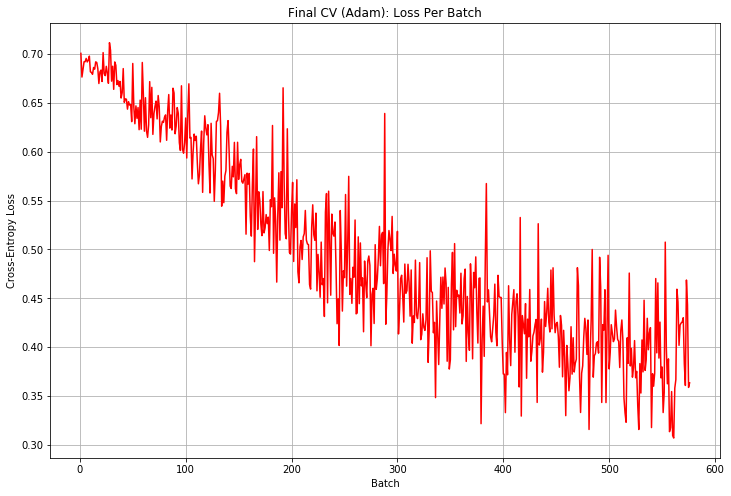

In [42]:
ptmod.plot_loss(avg_2darrays(losses), "Final CV (Adam)")

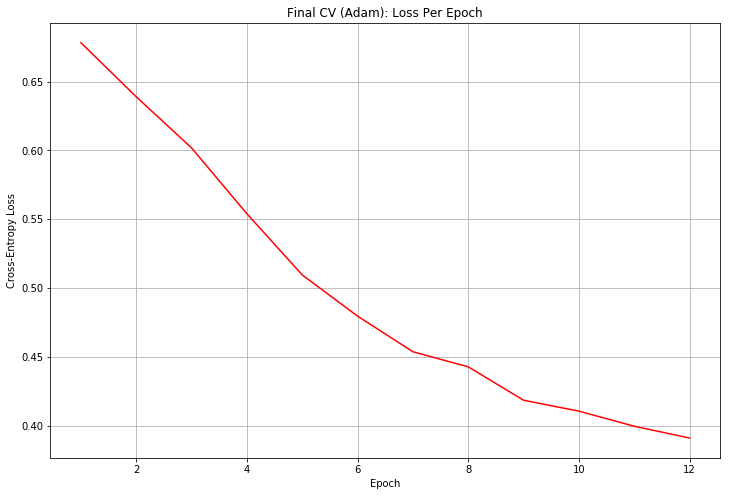

In [43]:
ptmod.plot_loss(avg_2darrays(losses), "Final CV (Adam)", plot_values='epoch')

In [6]:
def get_stats_per_epoch(num_epochs, kfolds, params, datagroup):
    """
    Brute force way to do this, but I'm not rewriting fit and/or crossval 
    today...
    """
    
    scores_by_epoch = {}
    for epoch in range(1, num_epochs+1):
        print("\n\n" + "*" * 40)
        print("*" + "Round {}".format(epoch).center(38) + "*")
        print("*" * 40 + "\n")
        cv_scores, _, losses = ptmod.crossval(
            params,
            datagroup,
            0.25,
            partial(optim.Adam, lr=0.0002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01),
            nn.CrossEntropyLoss(),
            epoch,
            16,
            folds=kfolds,
            rs=42
        )
        scores_by_epoch[epoch] = {'scores': cv_scores, 'loss': losses}
        
    return scores_by_epoch

In [7]:
test_scores = get_stats_per_epoch(20, 5, params, sax1203_dg)



****************************************
*               Round 1                *
****************************************


*** Fold 1 ***

Train set length: 772
Test set length: 148
Random seed: 42

Epoch 1
 * Avg loss: 0.675	Time: 8158.851 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.602	0.568
Rec	0.317	0.295
Spec	0.882	0.871

*** Fold 2 ***

Train set length: 718
Test set length: 202
Random seed: 42

Epoch 1
 * Avg loss: 0.670	Time: 7787.645 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.648	0.619
Rec	0.666	0.627
Spec	0.630	0.609

*** Fold 3 ***

Train set length: 759
Test set length: 161
Random seed: 42

Epoch 1
 * Avg loss: 0.668	Time: 7679.238 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.650	0.609
Rec	0.682	0.608
Spec	0.616	0.610

*** Fold 4 ***

Train set length: 720
Test set length: 200
Random seed: 42

Epoch 1
 * Avg loss:

 * Avg loss: 0.683	Time: 8673.893 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.661	Time: 8907.878 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.640	Time: 8932.468 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.589	Time: 9226.132 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.539	Time: 9047.471 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.757	0.761
Rec	0.811	0.856
Spec	0.706	0.638

*** Fold 2 ***

Train set length: 731
Test set length: 189
Random seed: 42

Epoch 1
 * Avg loss: 0.678	Time: 8112.059 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.636	Time: 8443.173 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.594	Time: 8594.823 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.541	Time: 8992.974 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.517	Time: 8663.758 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.773	0.714
Rec	0.827	0.706
Spec	0.716	0.721

*** Fo

 * Avg loss: 0.679	Time: 9223.064 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.657	Time: 8778.730 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.640	Time: 10344.832 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.627	Time: 10141.507 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.558	Time: 10611.359 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.493	Time: 11869.037 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.469	Time: 10839.246 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.797	0.725
Rec	0.790	0.719
Spec	0.804	0.731

*** Fold 5 ***

Train set length: 732
Test set length: 188
Random seed: 42

Epoch 1
 * Avg loss: 0.688	Time: 9122.238 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.638	Time: 8901.495 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.585	Time: 11239.948 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.566	Time: 11184.515 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.517	Time: 9343.442 

 * Avg loss: 0.576	Time: 8903.524 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.530	Time: 10154.679 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.499	Time: 10373.431 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.477	Time: 10241.165 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.442	Time: 10255.630 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.438	Time: 8590.465 ms
 * Weights updated: True
Epoch 9
 * Avg loss: 0.411	Time: 8606.012 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.818	0.763
Rec	0.874	0.802
Spec	0.762	0.724

*** Fold 5 ***

Train set length: 734
Test set length: 186
Random seed: 42

Epoch 1
 * Avg loss: 0.678	Time: 8811.052 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.657	Time: 9942.063 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.637	Time: 9368.388 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.614	Time: 8679.948 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.566	Time: 9981.918 ms


 * Avg loss: 0.681	Time: 8512.704 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.658	Time: 8831.449 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.649	Time: 9034.489 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.629	Time: 8775.822 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.604	Time: 10004.004 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.524	Time: 9877.182 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.472	Time: 8868.273 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.449	Time: 9315.487 ms
 * Weights updated: True
Epoch 9
 * Avg loss: 0.432	Time: 9411.921 ms
 * Weights updated: True
Epoch 10
 * Avg loss: 0.414	Time: 9363.797 ms
 * Weights updated: True
Epoch 11
 * Avg loss: 0.399	Time: 9478.266 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.827	0.744
Rec	0.779	0.724
Spec	0.876	0.761

*** Fold 4 ***

Train set length: 726
Test set length: 194
Random seed: 42

Epoch 1
 * Avg loss: 0.680	Time: 8273.023 ms
 

 * Avg loss: 0.668	Time: 7891.209 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.608	Time: 7816.613 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.564	Time: 7971.351 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.524	Time: 8033.943 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.493	Time: 7907.386 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.465	Time: 7959.123 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.450	Time: 7907.491 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.423	Time: 7831.362 ms
 * Weights updated: True
Epoch 9
 * Avg loss: 0.415	Time: 7808.173 ms
 * Weights updated: True
Epoch 10
 * Avg loss: 0.399	Time: 8009.135 ms
 * Weights updated: True
Epoch 11
 * Avg loss: 0.379	Time: 7774.922 ms
 * Weights updated: True
Epoch 12
 * Avg loss: 0.365	Time: 7771.716 ms
 * Weights updated: True
Epoch 13
 * Avg loss: 0.353	Time: 7836.430 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.835	0.702
Rec	0.918	0.883

 * Avg loss: 0.395	Time: 8419.221 ms
 * Weights updated: True
Epoch 13
 * Avg loss: 0.378	Time: 8408.751 ms
 * Weights updated: True
Epoch 14
 * Avg loss: 0.388	Time: 8881.966 ms
 * Weights updated: True
Epoch 15
 * Avg loss: 0.360	Time: 8369.144 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.868	0.794
Rec	0.794	0.720
Spec	0.945	0.860

*** Fold 5 ***

Train set length: 752
Test set length: 168
Random seed: 42

Epoch 1
 * Avg loss: 0.681	Time: 8996.722 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.663	Time: 9101.133 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.648	Time: 9646.791 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.631	Time: 10152.869 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.611	Time: 9084.626 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.561	Time: 8660.112 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.485	Time: 8584.152 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.452	Time: 8745.909 ms


 * Avg loss: 0.360	Time: 7949.274 ms
 * Weights updated: True
Epoch 16
 * Avg loss: 0.358	Time: 7975.439 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.846	0.796
Rec	0.789	0.736
Spec	0.904	0.853

CV Average Scores
Score	Train	Test
------------------------
Acc	0.850	0.792
Rec	0.803	0.753
Spec	0.898	0.829


****************************************
*               Round 17               *
****************************************


*** Fold 1 ***

Train set length: 738
Test set length: 182
Random seed: 42

Epoch 1
 * Avg loss: 0.669	Time: 8715.308 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.626	Time: 8958.189 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.567	Time: 8504.740 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.533	Time: 8557.907 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.519	Time: 9342.700 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.480	Time: 9509.296 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0

 * Avg loss: 0.385	Time: 7875.864 ms
 * Weights updated: True
Epoch 17
 * Avg loss: 0.361	Time: 8119.367 ms
 * Weights updated: True
Epoch 18
 * Avg loss: 0.353	Time: 7918.305 ms
 * Weights updated: True
Epoch 19
 * Avg loss: 0.357	Time: 7879.186 ms
 * Weights updated: True

Training Complete

Score	Train	Test
------------------------
Acc	0.803	0.806
Rec	0.623	0.648
Spec	0.981	0.966

*** Fold 2 ***

Train set length: 737
Test set length: 183
Random seed: 42

Epoch 1
 * Avg loss: 0.681	Time: 7793.674 ms
 * Weights updated: True
Epoch 2
 * Avg loss: 0.643	Time: 7875.997 ms
 * Weights updated: True
Epoch 3
 * Avg loss: 0.575	Time: 7950.887 ms
 * Weights updated: True
Epoch 4
 * Avg loss: 0.524	Time: 8293.024 ms
 * Weights updated: True
Epoch 5
 * Avg loss: 0.503	Time: 8466.161 ms
 * Weights updated: True
Epoch 6
 * Avg loss: 0.472	Time: 8416.722 ms
 * Weights updated: True
Epoch 7
 * Avg loss: 0.452	Time: 8478.257 ms
 * Weights updated: True
Epoch 8
 * Avg loss: 0.487	Time: 8361.824 ms
 

In [2]:
# test_scores_20 = test_scores

# with open("../data/cv20_scores_by_epoch.p", 'wb') as pf:
#     pickle.dump(test_scores_20, pf)

NameError: name 'test_scores_20' is not defined

In [3]:
# with open("../data/cv20_scores_by_epoch.p", 'rb') as pf:
#     test_scores = pickle.load(pf)

EOFError: Ran out of input

In [25]:
test_scores[14] = {'scores': cv_scores, 'loss': losses}

In [17]:
test_scores[3]['scores']

defaultdict(list,
            {'acc': [0.71348083808339746, 0.69458521267135165],
             'rec': [0.78676158615519631, 0.76928459049334996],
             'spec': [0.63858067600720092, 0.62765367080777534]})

In [26]:
[test_scores[i]['scores']['acc'][0] for i in range(1, len(test_scores)+1)]

[0.63901799725013597,
 0.67355454625655786,
 0.71348083808339746,
 0.73050751890856458,
 0.75373611345128411,
 0.78668294502681146,
 0.79022946827115237,
 0.81114183438327137,
 0.81766107154324352,
 0.82718206251954085,
 0.82338746398222151,
 0.82810246267753218,
 0.82350590797273215,
 0.84328861329839122,
 0.84835818144409225,
 0.84995670168794712,
 0.84919673597922807,
 0.86471223503371897,
 0.8501057965576051,
 0.87344021276719042]

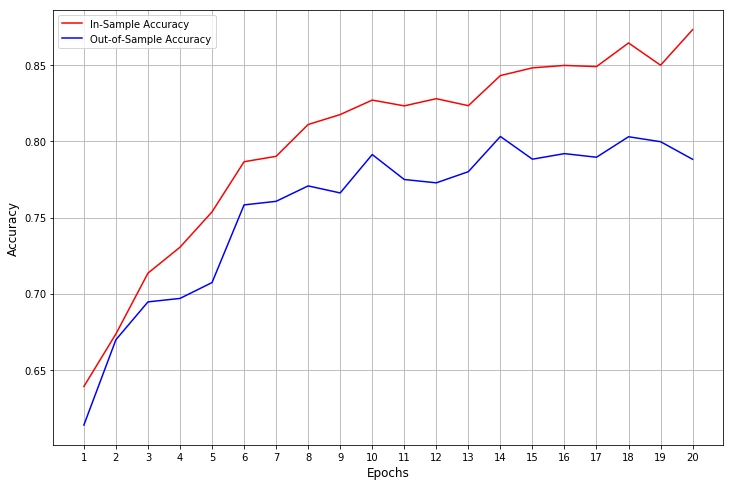

In [35]:
x = range(1, len(test_scores)+1)
y_train = [test_scores[i]['scores']['acc'][0] for i in range(1, len(test_scores)+1)]
y_test = [test_scores[i]['scores']['acc'][1] for i in range(1, len(test_scores)+1)]

fig = plt.figure(figsize=(12,8))
plt.plot(x, y_train, "r-", label="In-Sample Accuracy")
plt.plot(x, y_test, "b-", label="Out-of-Sample Accuracy")
plt.grid()
plt.legend(fontsize=12)
plt.xticks([i+1 for i in range(20)])
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
# plt.title("In- and Out-of-Sample Accuracy by Epoch Length", fontsize=16)

plt.savefig("../specs/acc_by_epoch.png", dpi=200);